In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My\ Drive

/content/drive/My Drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
!pip3 install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install typeguard

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.9MB 21kB/s 
     |████████████████████████████████| 8.8MB 24.4MB/s 
  Found existing installation: torch 1.3.0+cu100
    Uninstalling torch-1.3.0+cu100:
      Successfully uninstalled torch-1.3.0+cu100
  Found existing installation: torchvision 0.4.1+cu100
    Uninstalling torchvision-0.4.1+cu100:
      Successfully uninstalled torchvision-0.4.1+cu100


In [0]:
#!unzip 'data.zip'

In [0]:
from fastai import *
from fastai.vision import *
import random
bs = 32
#random.seed(23)

In [6]:
path_img = Path('data')## Loading data 
#data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs), check_ext=False)## Normalizing data based on Image net parameters
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1180 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: data;

Valid: LabelList (397 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: data;

Test: None

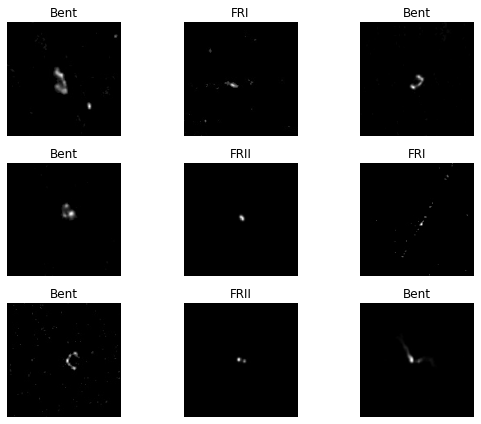

In [7]:
data.show_batch(rows=3, figsize=(8,6))

In [8]:
learn = cnn_learner(data, models.densenet201, metrics=accuracy)
learn.freeze()

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 56.1MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.01E-06
Min loss divided by 10: 4.17E-03


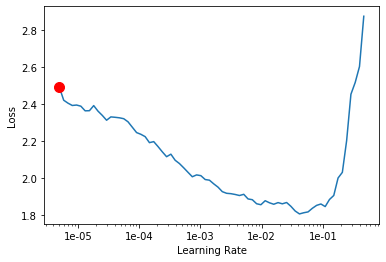

In [9]:
learn.lr_find(start_lr=1e-6, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.451305,1.172903,0.551637,01:34


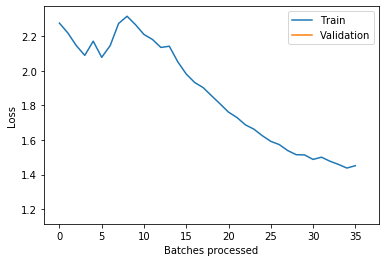

In [10]:
learn.fit_one_cycle(1, max_lr=slice(1e-4,1e-2))
#learn.save('31stage1')
learn.recorder.plot_losses()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-05
Min loss divided by 10: 3.63E-05


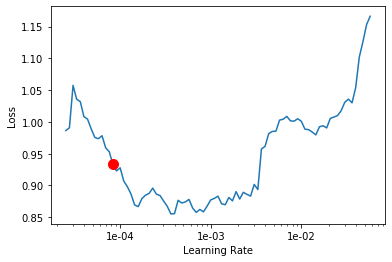

In [11]:
learn.unfreeze()
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.956648,1.322587,0.400504,00:47
1,0.830506,0.725513,0.745592,00:47
2,0.736894,0.514939,0.803526,00:47


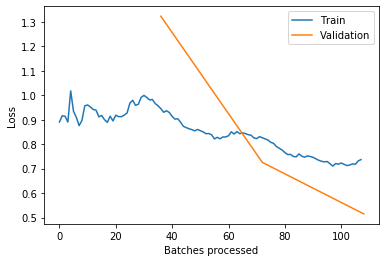

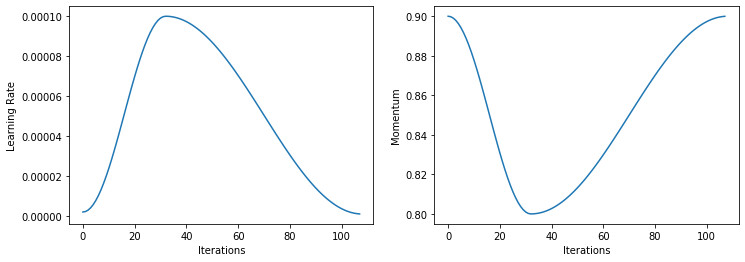

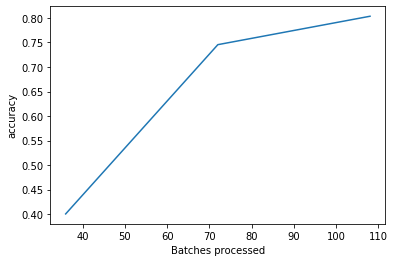

In [12]:
learn.fit_one_cycle(3, max_lr=slice(3e-5, 1e-4), div_factor=50, final_div=100, wd=1e-4, moms=(0.9, 0.8))
#learn.save('stage-2')
learn.recorder.plot_losses()
# schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,0.579410,0.861771,0.745592,00:47
1,0.573060,0.635639,0.765743,00:47
2,0.521910,0.549044,0.803526,00:47
3,0.463300,0.402120,0.874055,00:47
4,0.413994,0.312019,0.894207,00:47
5,0.365185,0.348391,0.894207,00:47
6,0.319640,0.309597,0.901763,00:47
7,0.295435,0.289699,0.914358,00:47
8,0.270728,0.283677,0.909320,00:47
9,0.264405,0.276467,0.906801,00:47


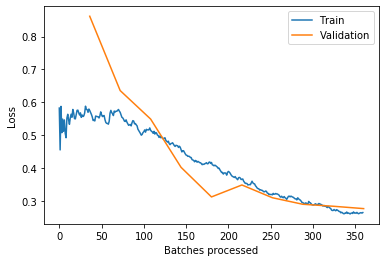

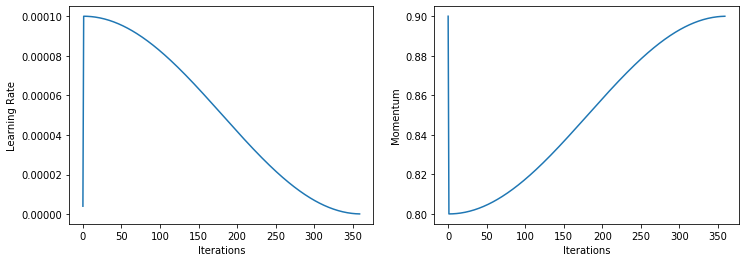

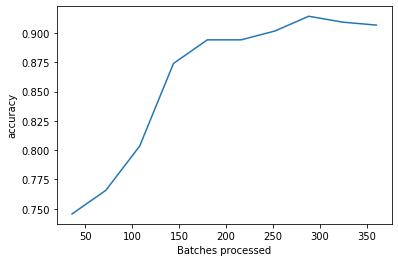

In [13]:
learn.fit_one_cycle(cyc_len=10, max_lr=slice(3e-5, 1e-4), pct_start=0, final_div=1000, wd=1e-4, moms=(0.9, 0.8)) # warm restart: pct_start=0
#learn.save('stage-3')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [0]:
learn.save('rg5-2nov-201')

In [0]:
learn.load('rg5-2nov-201')
interp = ClassificationInterpretation.from_learner(learn)

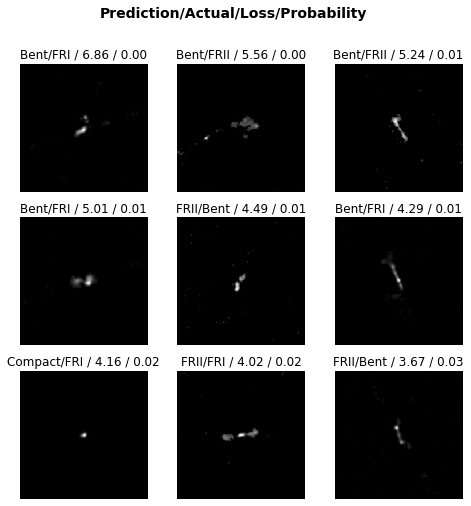

In [16]:
interp.plot_top_losses(9, figsize=(8,8))

In [17]:
losses, indexes = interp.top_losses(10)

top_loss_paths = data.valid_ds.x.items[indexes]

print(top_loss_paths)

[PosixPath('data/valid/FRI/J143521.30-024051.7.jpg') PosixPath('data/valid/FRII/J153004.69+290009.3.jpg')
 PosixPath('data/valid/FRII/J145131.67+213639.9.jpeg') PosixPath('data/valid/FRI/J143825.92-010001.5.jpg')
 PosixPath('data/valid/Bent/J143505.58-040920.9.jpg') PosixPath('data/valid/FRI/J143147.54+605109.5.jpg')
 PosixPath('data/valid/FRI/J141104.33-030043.3.jpeg') PosixPath('data/valid/FRI/J140215.22+231803.7.jpeg')
 PosixPath('data/valid/Bent/J163424.19+341543.3.jpeg') PosixPath('data/valid/FRI/J143410.56+013646.9.jpg')]


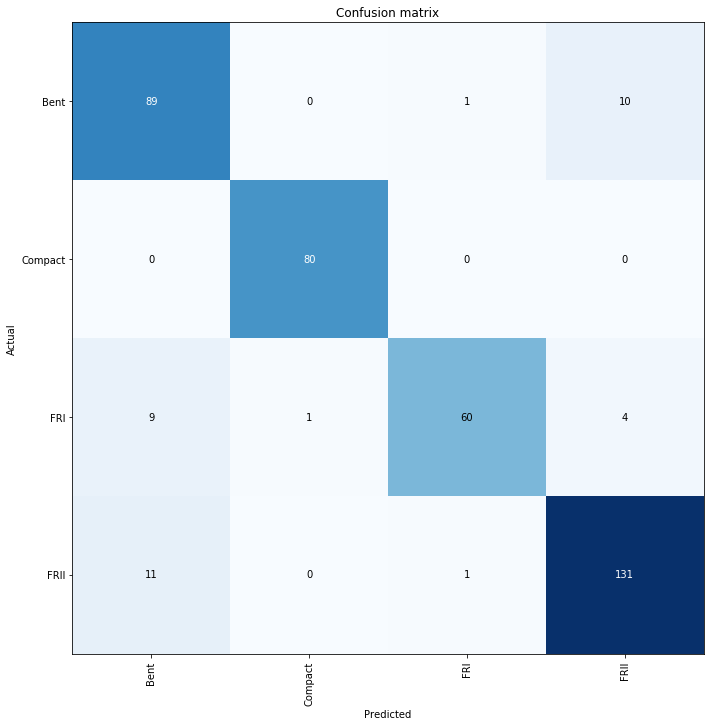

In [18]:
interp.plot_confusion_matrix(figsize=(10,10))

In [19]:
path_img = Path('data')## Loading data 
#data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs), check_ext=False)## Normalizing data based on Image net parameters
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='test', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1180 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: data;

Valid: LabelList (404 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Compact,Compact,Compact,Compact,Compact
Path: data;

Test: None

In [0]:
learn = cnn_learner(data, models.densenet201, metrics=[accuracy])

In [0]:
learn = learn.load('rg5-2nov-201')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

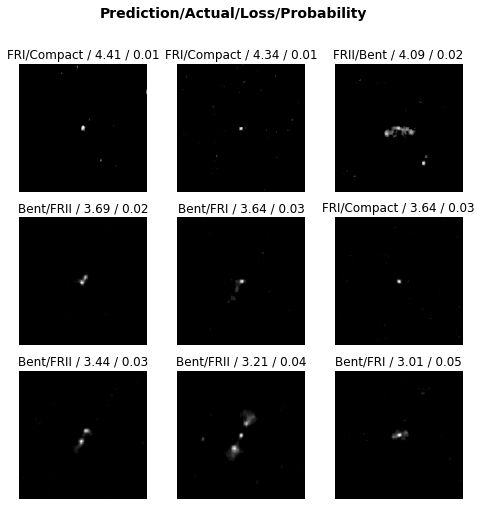

In [23]:
interp.plot_top_losses(9, figsize=(8,8))

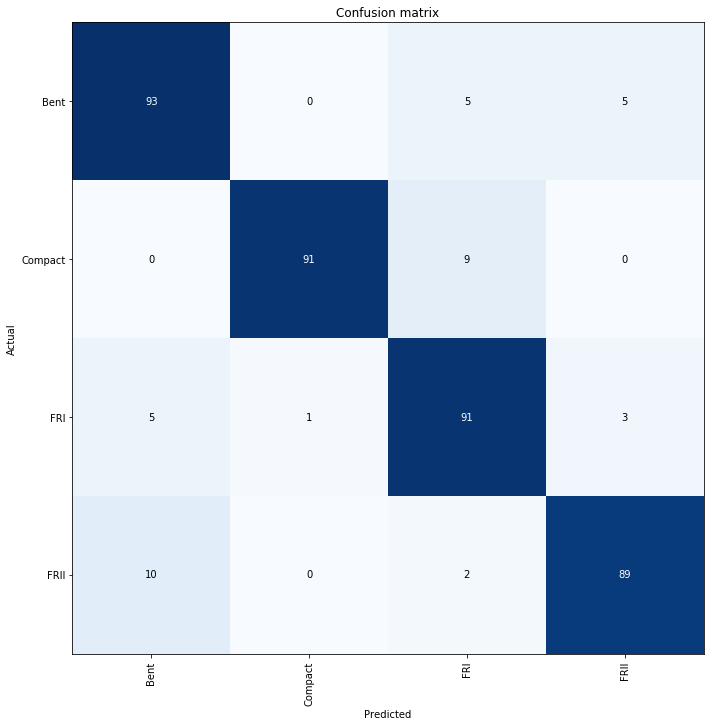

In [24]:
interp.plot_confusion_matrix(figsize=(10,10))

In [25]:
import glob

image_list = glob.glob('data/test/*/*')

Bent = 0
Pred_Bent=0
Compact=0
Pred_Compact=0
FRI=0
Pred_FRI=0
FRII=0
Pred_FRII = 0 

for each in image_list:
    img = open_image(each)
    each = each.split('/')
    rg_class = each[2]
    pred_class, pred_idx, outputs = learn.predict(img)
    pred_class = str(pred_class)
         
    if rg_class == 'Bent':
        Bent += 1
        if pred_class == 'Bent':
            Pred_Bent += 1
    elif rg_class == 'Compact':
        Compact += 1
        if pred_class == 'Compact':
            Pred_Compact += 1
    elif rg_class == 'FRI':
        FRI += 1
        if pred_class == 'FRI':
            Pred_FRI += 1
    elif rg_class == 'FRII':
        FRII += 1
        if pred_class == 'FRII':
            Pred_FRII += 1
            
    
print('Bent accuracy: ' + str(Pred_Bent) + '/' + str(Bent))
print('Compact accuracy: ' + str(Pred_Compact) + '/' + str(Compact))
print('FR1 accuracy: ' + str(Pred_FRI) + '/' + str(FRI) )
print('FR2 accuracy: ' + str(Pred_FRII) + '/' + str(FRII) )

Bent accuracy: 93/103
Compact accuracy: 91/100
FR1 accuracy: 91/100
FR2 accuracy: 89/101
